In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from silence_tensorflow import silence_tensorflow
import os
from preparing_data import *

%matplotlib inline
silence_tensorflow()

### Create directories for images to be split

In [2]:
ZIP_PATH = os.path.join(os.getcwd(), 'data/letters/archive.zip')
UNZIP_PATH = os.path.join(os.getcwd(), 'data/letters/')

unzip_data(ZIP_PATH, UNZIP_PATH, True)

In [3]:
TRAINING_PATH = os.path.join(UNZIP_PATH, 'Train_Alphabet/')
TEST_PATH = os.path.join(UNZIP_PATH, 'Test_Alphabet/')

os.rename(TRAINING_PATH, os.path.join(UNZIP_PATH, 'Training/'))
os.rename(TEST_PATH, os.path.join(UNZIP_PATH, 'Test/'))

TEST_PATH = os.path.join(UNZIP_PATH, 'Test/')
TRAINING_PATH = os.path.join(UNZIP_PATH, 'Training/')
VALIDATION_PATH = os.path.join(UNZIP_PATH, 'Validation/')

assert os.path.isdir(TRAINING_PATH)

assert os.path.isdir(TEST_PATH)

In [4]:
aux = data_counter(TRAINING_PATH, 'Trainig')
aux = data_counter(TEST_PATH, 'Test')

Number of files in Trainig is 24300
Number of files in Test is 810


In [5]:
split_test_val(TEST_PATH, VALIDATION_PATH, 0.7)

In [6]:
aux = data_counter(TRAINING_PATH, 'Trainig')
aux = data_counter(VALIDATION_PATH, 'Validation')
aux = data_counter(TEST_PATH, 'Test')

Number of files in Trainig is 24300
Number of files in Validation is 1890
Number of files in Test is 810


### Load data from directories

In [16]:
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

training_data = tf.keras.utils.image_dataset_from_directory(directory=TRAINING_PATH,
                                                            labels='inferred',
                                                            label_mode='int',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE)

test_data = tf.keras.utils.image_dataset_from_directory(directory=TEST_PATH,
                                                        batch_size=1,
                                                        image_size=IMAGE_SIZE,
                                                        labels='inferred',
                                                        label_mode='int',
                                                        shuffle=False)

validation_data = tf.keras.utils.image_dataset_from_directory(directory=VALIDATION_PATH,
                                                              labels='inferred',
                                                              label_mode='int',
                                                              batch_size=BATCH_SIZE,
                                                              image_size=IMAGE_SIZE)

assert training_data.class_names == validation_data.class_names == test_data.class_names                                                        

Found 24300 files belonging to 27 classes.
Found 810 files belonging to 27 classes.
Found 1890 files belonging to 27 classes.


In [8]:
names = training_data.class_names
print(names)

['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


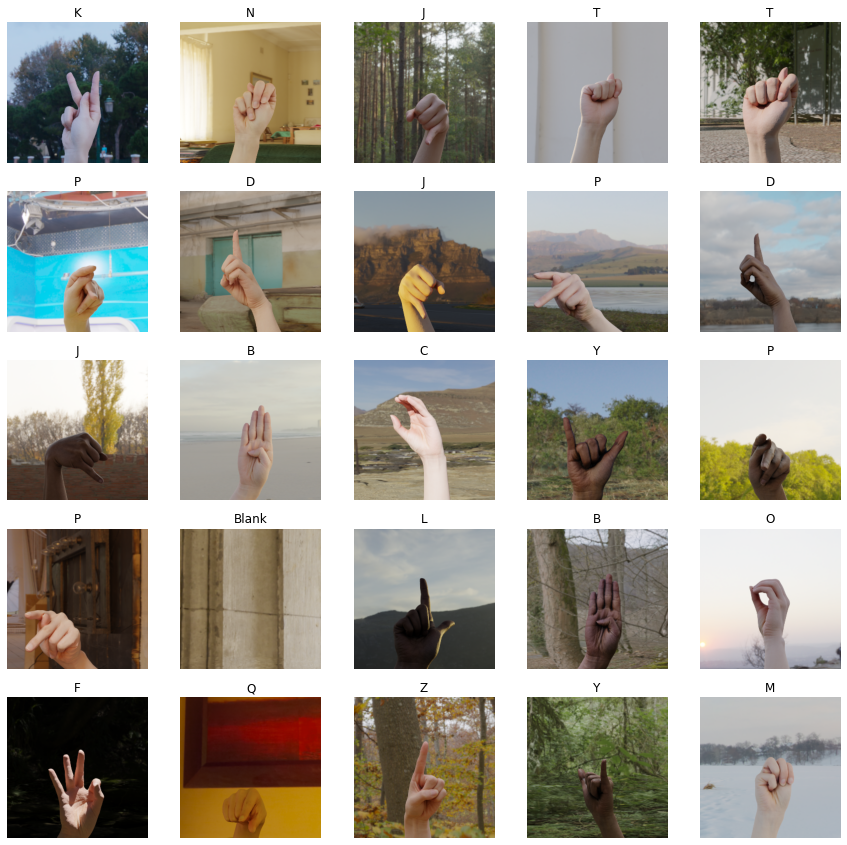

In [9]:
training_samples = list(training_data.take(1).as_numpy_iterator())

# print(training_samples.shape)
plt.figure(figsize=(15,15))
for image, label in training_samples:
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image[i].astype('uint8'))
        plt.title(names[label[i]])
        plt.axis('off')

Show several examples from training set.

### Image data augumentation

In [10]:
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import RandomContrast, RandomZoom, RandomRotation, RandomFlip, RandomBrightness, Rescaling

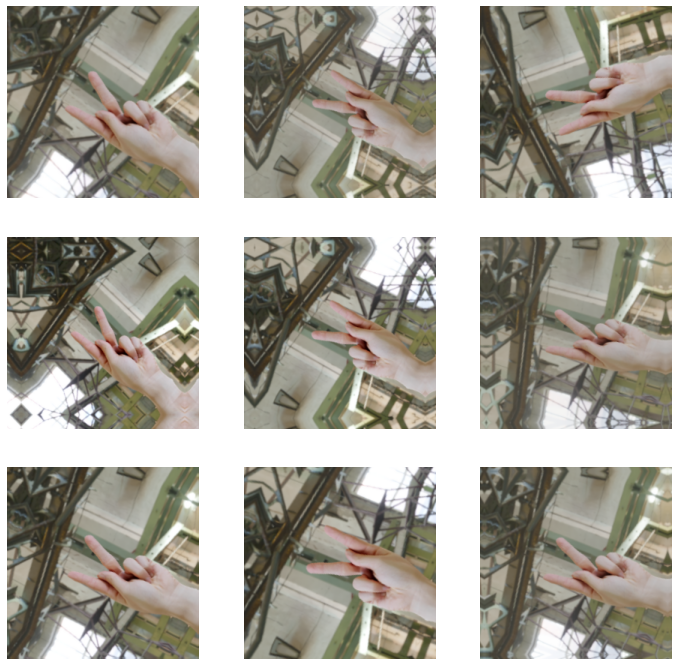

In [11]:
image_preprocessing = Sequential([
    RandomContrast(factor=(0.1, 0.3)),
    RandomFlip('horizontal'),
    RandomRotation(factor=(0.1, 0.3)),
    RandomZoom(0.2)
])

plt.figure(figsize=(12,12))
for image, label in training_data.take(1):
    for i in range(9):
        augumented = image_preprocessing(image)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augumented[0].numpy().astype('uint8'))
        plt.axis('off')

Shown data augumentation results

## Creating the model

In [12]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, RemoteMonitor

In [19]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.99:
            print(f'\nTraining accuracy greater than or equal to 99% so stop training on epoch {epoch+1}.')
            self.model.stop_training = True
        if logs.get('val_accuracy') >= 0.98:
            print(f'\nValidation accuracy greater than or equal to 98% so stop training on epoch {epoch+1}.')


os.makedirs(os.path.join(os.getcwd(), 'saved_models/letters_checkpoint/'))
letters_checkpoint = os.path.join(os.getcwd(), 'saved_models/letters_checkpoint/cp.cpkt')

checkpoint = ModelCheckpoint(filepath=letters_checkpoint,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             save_freq='epoch',
                             save_weights_only=True,
                             verbose=2)

remote_monitor = RemoteMonitor()
callback = MyCallback()

#### Implement function creating model

In [14]:
def create_model():
    inpt = Input(shape=(256, 256, 3))
    x = Rescaling(scale=1./255)(inpt)
    x = image_preprocessing(x, training=True)
    x = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(len(names), activation='softmax')(x)

    model = Model(inpt, x)
    return model

In [20]:
inception_resnet = create_model()
inception_resnet.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

with tf.device('/gpu:0'):
    inception_resnet.fit(training_data,
                        epochs=20,
                        validation_data=validation_data,
                        callbacks = [callback, checkpoint, remote_monitor])

Epoch 1/20
760/760 [==============================] - ETA: 0s - loss: 1.1693 - accuracy: 0.7263
Epoch 1: val_accuracy improved from -inf to 0.96508, saving model to /home/barti/deep/tenorflow-projects/saved_models/letters_checkpoint/cp.cpkt
760/760 [==============================] - 429s 549ms/step - loss: 1.1693 - accuracy: 0.7263 - val_loss: 0.1129 - val_accuracy: 0.9651
Epoch 2/20
760/760 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.9712
Epoch 2: val_accuracy did not improve from 0.96508
760/760 [==============================] - 414s 545ms/step - loss: 0.0952 - accuracy: 0.9712 - val_loss: 0.1259 - val_accuracy: 0.9646
Epoch 3/20
760/760 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9819
Epoch 3: val_accuracy did not improve from 0.96508
760/760 [==============================] - 416s 547ms/step - loss: 0.0615 - accuracy: 0.9819 - val_loss: 0.1294 - val_accuracy: 0.9624
Epoch 4/20
760/760 [==============================] - ETA: 0

In [24]:
#Trying to minimize loss as much as possible so we are running for few more epochs.
with tf.device('/gpu:0'):
    inception_resnet.fit(training_data,
                        epochs=5,
                        validation_data=validation_data,
                        callbacks = [checkpoint])

/bin/bash: /home/barti/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Epoch 1/5
760/760 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9806
Epoch 1: val_accuracy did not improve from 0.97989
760/760 [==============================] - 403s 530ms/step - loss: 0.0712 - accuracy: 0.9806 - val_loss: 0.1141 - val_accuracy: 0.9709
Epoch 2/5
760/760 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9901
Epoch 2: val_accuracy improved from 0.97989 to 0.98730, saving model to /home/barti/deep/tenorflow-projects/saved_models/letters_checkpoint/cp.cpkt
760/760 [==============================] - 408s 537ms/step - loss: 0.0344 - accuracy: 0.9901 - val_loss: 0.0421 - val_accuracy: 0.9873
Epoch 3/5
760/760 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9864
Epoch 3: val_accuracy did not improve from 0.98730
760/760 [==============================] - 388s 511ms/step - loss: 0.0513 - a

## Model evaluation

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [26]:
#Loading best weights
inception_resnet.load_weights(letters_checkpoint)

#Evaluate on test data
inception_resnet.evaluate(test_data)

810/810 [==============================] - 24s 29ms/step - loss: 0.0203 - accuracy: 0.9963


[0.020253511145710945, 0.9962962865829468]

In [47]:
test_list = list(test_data.as_numpy_iterator())

evaluations = np.array([(names[label[0]], names[np.argmax(inception_resnet.predict(image, verbose=0))]) for image, label in test_list])
evaluations.shape

(810, 2)

Text(0.5, 1.0, 'Confusion Matrix')

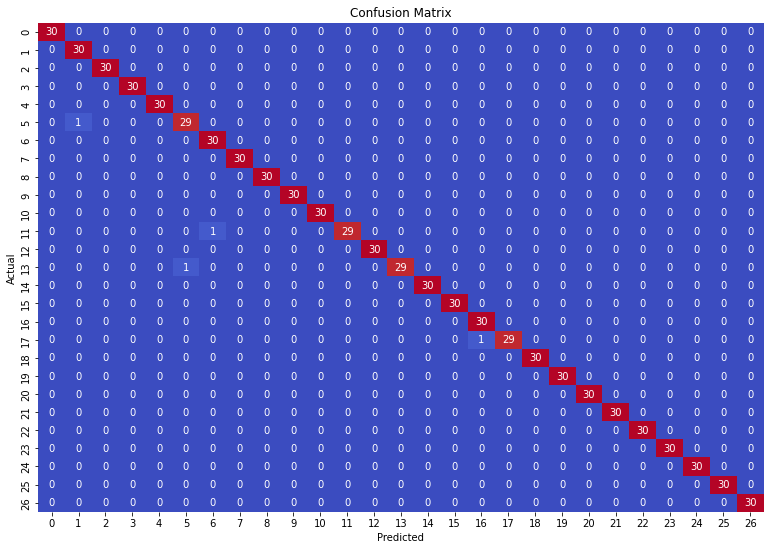

In [59]:
y_true = evaluations[:, 0]
y_pred = evaluations[:, 1]


plt.figure(figsize=(13, 9))
matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=names)
sns.heatmap(matrix, annot=True, cmap='coolwarm', cbar=False, vmin=0, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [53]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        30
           B       0.97      1.00      0.98        30
       Blank       1.00      1.00      1.00        30
           C       1.00      1.00      1.00        30
           D       1.00      1.00      1.00        30
           E       0.97      0.97      0.97        30
           F       0.97      1.00      0.98        30
           G       1.00      1.00      1.00        30
           H       1.00      1.00      1.00        30
           I       1.00      1.00      1.00        30
           J       1.00      1.00      1.00        30
           K       1.00      0.97      0.98        30
           L       1.00      1.00      1.00        30
           M       1.00      0.97      0.98        30
           N       1.00      1.00      1.00        30
           O       1.00      1.00      1.00        30
           P       0.97      1.00      0.98        30
           Q       1.00    

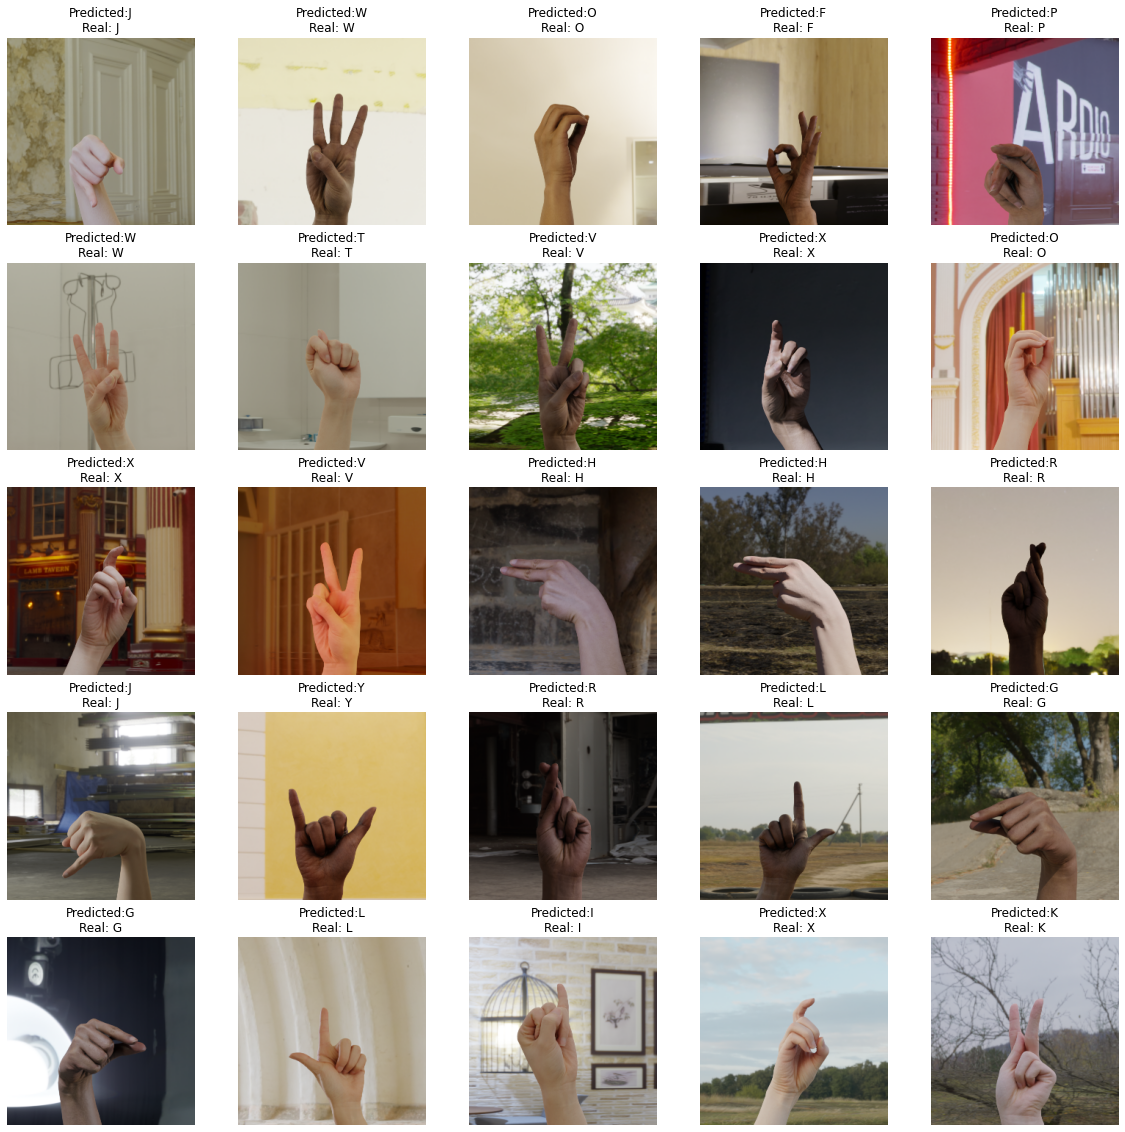

In [60]:
plt.figure(figsize=(20, 20))
i = 0
for image, label in random.sample(test_list, 25):
    prediction = np.argmax(inception_resnet.predict(image, verbose=0))
    title = f"Predicted:{names[prediction]}\nReal: {str(names[label[0]])}"
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image[0].astype('uint8'))
    plt.title(title)
    plt.axis('off')
    i+=1

Our model initialized with imagenet weights scored 99.63% on test set. It means that model missclassified only 3 out of 810 images. We can consider this model as a big sucess.